In [1]:
# !pip install pycocoevalcap
# !pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import textwrap
import torch
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image
from pkg_resources import packaging
from nltk import edit_distance
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from sklearn.model_selection import train_test_split
from torchvision import transforms



print("Torch version:", torch.__version__)

import open_clip

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_123642/890193654.py:11: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging


Torch version: 2.1.0a0+32f93b1


In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, _, transform = open_clip.create_model_and_transforms(
    model_name = "coca_ViT-L-14",
    pretrained = "./open_clip/open_clip_pytorch_model.bin"
)
model.eval()
print(device)

cuda:0


In [4]:
model = model.to(device)

In [5]:
# res_model = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2)
# res_model.modules

In [6]:
def clean_text(txt):
    # Lower
    text = txt.lower()

    # Remove punctuations and words whose length no greater than 1
    text = re.sub("[^a-z]+"," ",text)    
    text = text.split()
    text = [s for s in text if len(s) > 1]
    text = " ".join(text)
    
    return text

In [7]:
# Load Flickr8k dataset

annotations_path = "./data/"
annotations = pd.read_csv(annotations_path + "captions.txt")
print(annotations[:5])

                       image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  


In [8]:
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [9]:
sp = annotations['image'].drop_duplicates()
# sp = sp.sample(100, replace = False)

In [10]:
new_captions = {}
start_marker = "<start_of_text>"
end_marker = "<end_of_text>"

i = 0
for image_name in sp:
    i += 1
    if i % 20 == 0:
        print(f"#{i} image captioning done.")
    image_path = annotations_path + "Images/" + image_name
    im = Image.open(image_path).convert("RGB")
    im = transform(im).unsqueeze(0).to(device)
    with torch.no_grad(), torch.cuda.amp.autocast():
        generated = model.generate(im)
#         res_generated = res_model.
    caption = open_clip.decode(generated[0])
    caption = caption.replace(start_marker, "")
    caption = caption.replace(end_marker, "")
    new_captions[image_name] = [caption]

#20 image captioning done.
#40 image captioning done.
#60 image captioning done.
#80 image captioning done.
#100 image captioning done.
#120 image captioning done.
#140 image captioning done.
#160 image captioning done.
#180 image captioning done.
#200 image captioning done.
#220 image captioning done.
#240 image captioning done.
#260 image captioning done.
#280 image captioning done.
#300 image captioning done.
#320 image captioning done.
#340 image captioning done.
#360 image captioning done.
#380 image captioning done.
#400 image captioning done.
#420 image captioning done.
#440 image captioning done.
#460 image captioning done.
#480 image captioning done.
#500 image captioning done.
#520 image captioning done.
#540 image captioning done.
#560 image captioning done.
#580 image captioning done.
#600 image captioning done.
#620 image captioning done.
#640 image captioning done.
#660 image captioning done.
#680 image captioning done.
#700 image captioning done.
#720 image captioning do

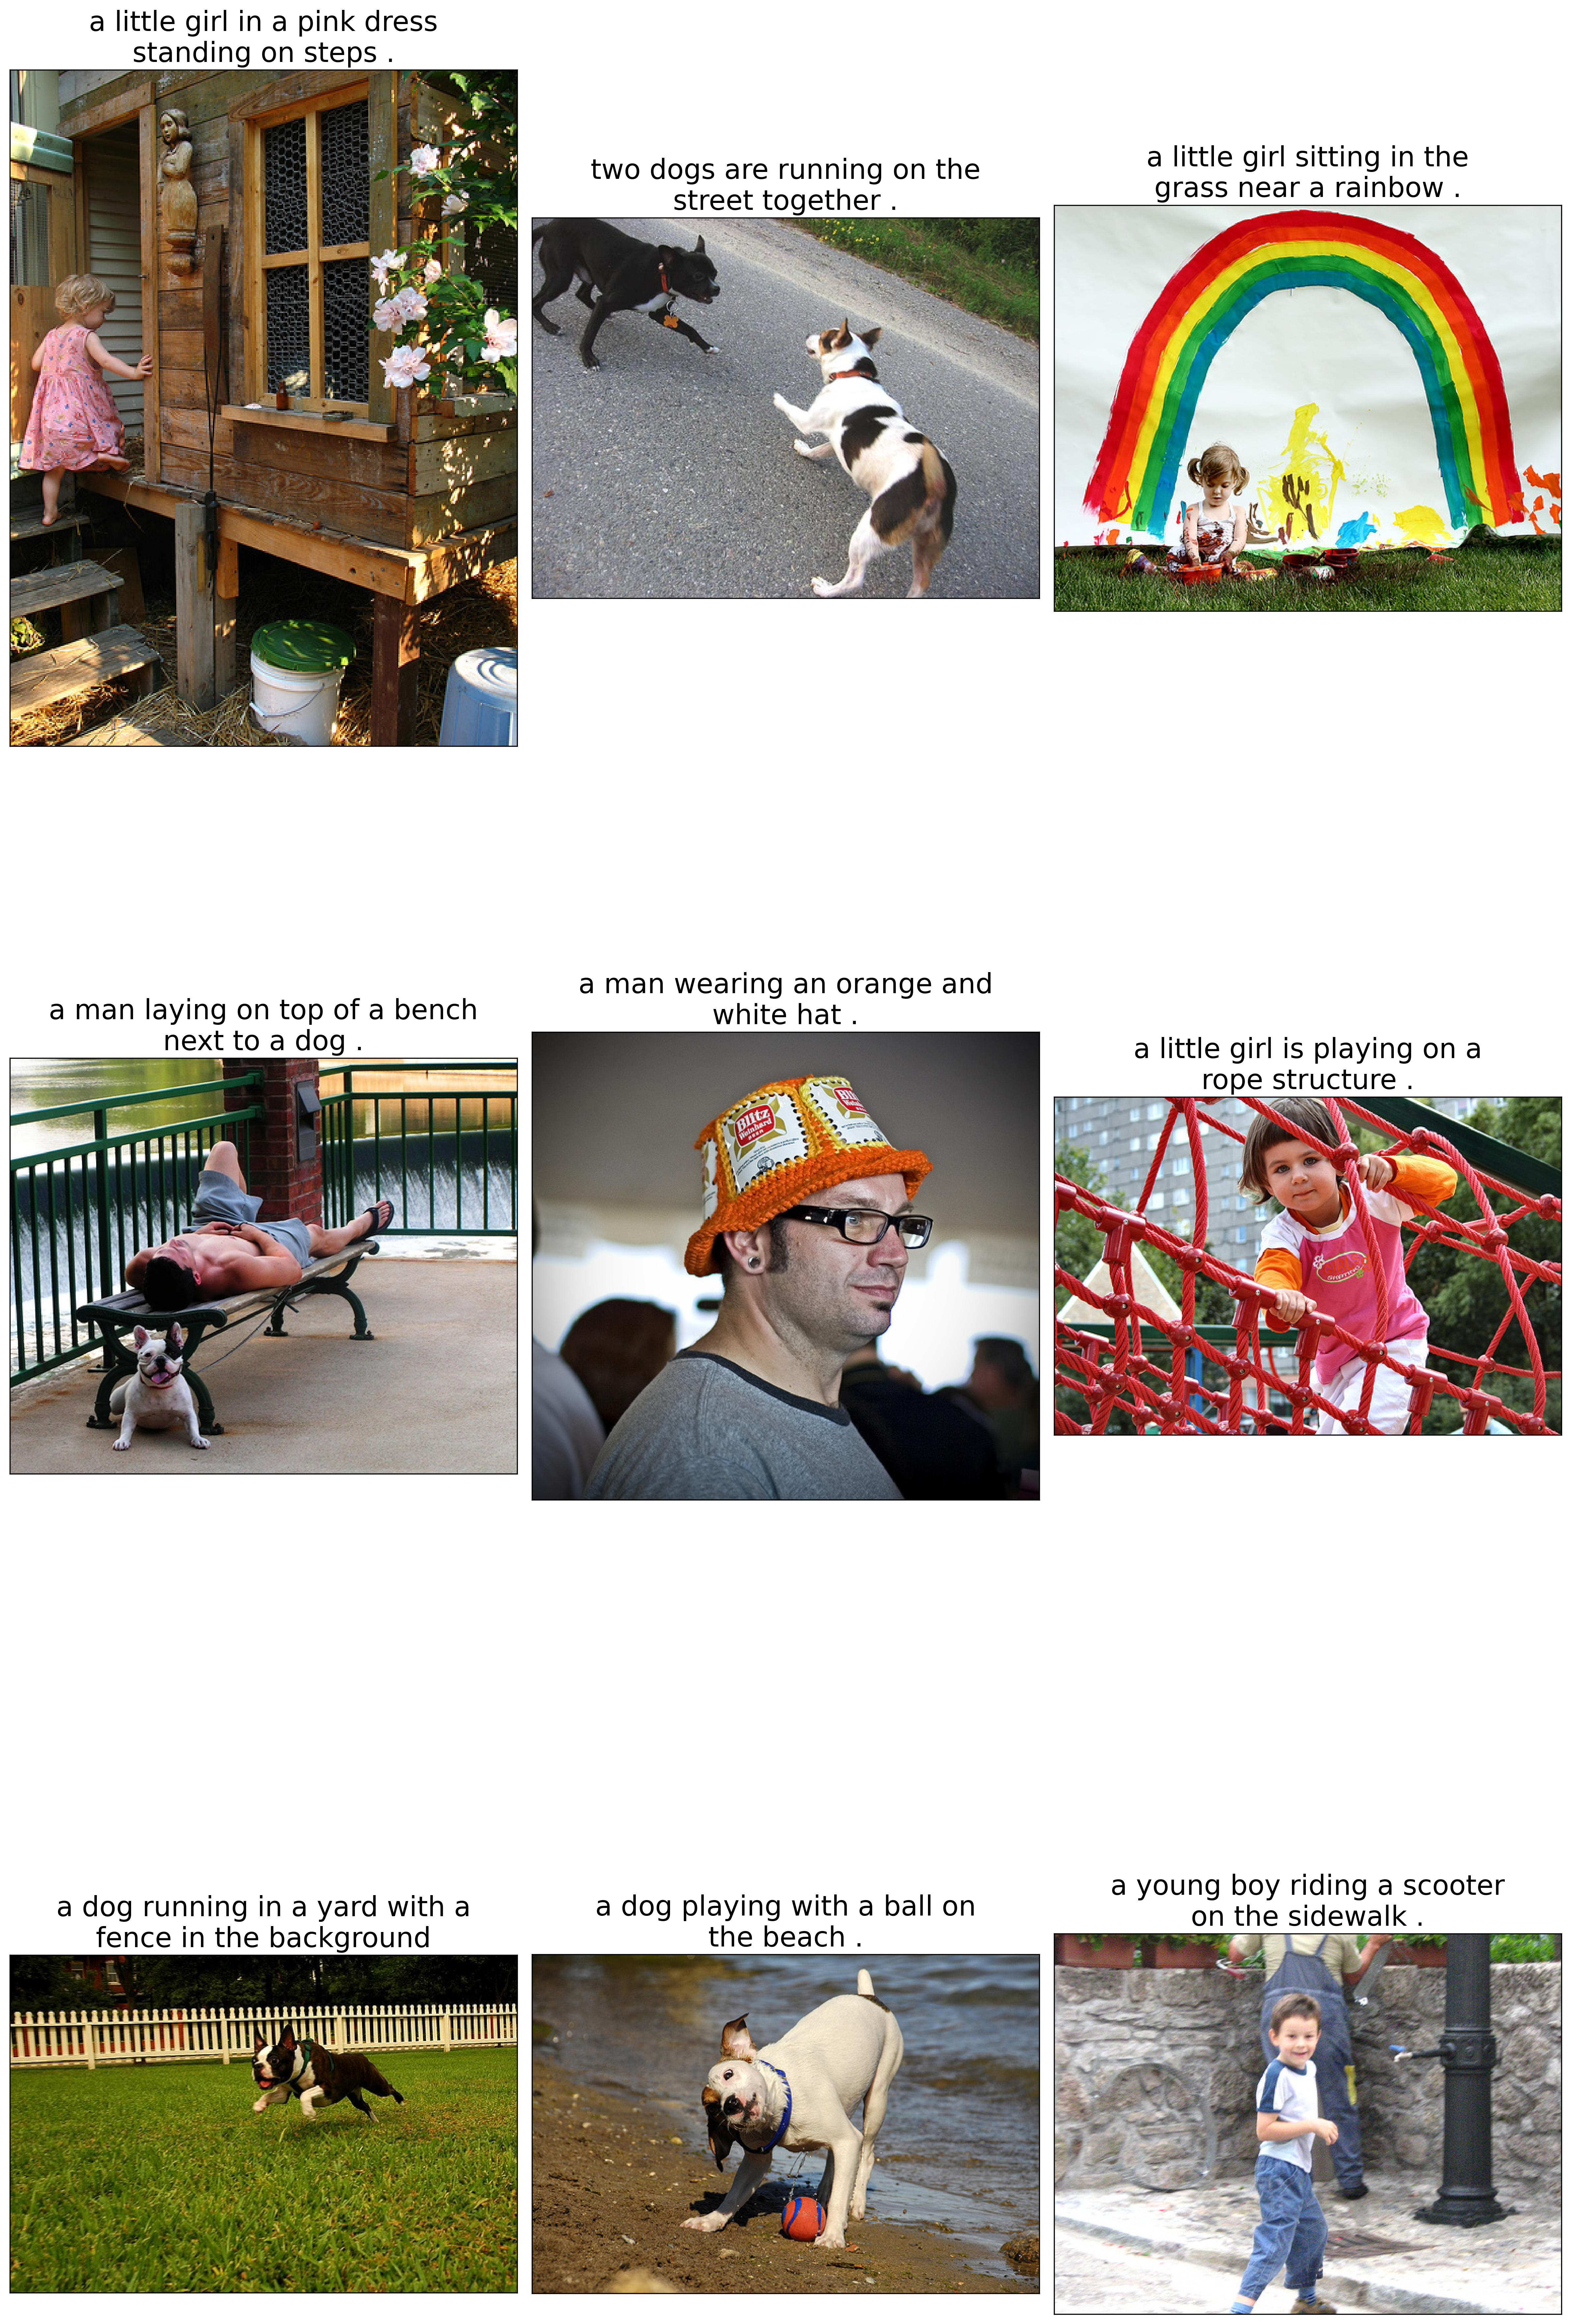

In [11]:
plt.figure(figsize = (16, 28), dpi = 300)
i = 0

for image_name, caption in list(new_captions.items())[:9]:
    caption = caption[0]
    image = Image.open(annotations_path + "Images/" + image_name).convert("RGB")
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    description_wrapped = "\n".join(textwrap.wrap(caption, width=30))
    plt.title(description_wrapped, size=20, y=1)
    plt.xticks([])
    plt.yticks([])
    i += 1

plt.tight_layout()

In [12]:
ps = PorterStemmer()

# Extract the stem of the words in a sentence, for example, "He was running." -> "he is run ." 
# Set recover = True to recover the splitted list back to a string.
def extract_stem(s, recover = True):
    words = word_tokenize(s)
    stemmed_words = [ps.stem(word) for word in words]
    if recover:
        return " ".join(stemmed_words)
    return stemmed_words

extract_stem("He is running.")

'he is run .'

In [13]:
bleu_scores_per_image = []
smooth = SmoothingFunction()
for image_name, caption in new_captions.items():
    reference_captions = annotations[annotations["image"] == image_name]["caption"]
    
    bleu = sentence_bleu([
        extract_stem(ref, False) for ref in reference_captions], 
        extract_stem(caption[0], False), 
        smoothing_function = smooth.method7
    )
    bleu_scores_per_image.append(bleu)

average_bleu_per_image = 100 * sum(bleu_scores_per_image) / len(bleu_scores_per_image)
print(f"Average BLEU Score per Image: {average_bleu_per_image : .2f}")


Average BLEU Score per Image:  39.81


In [15]:
d1 = copy.deepcopy(new_captions)
d2 = copy.deepcopy(annotations[annotations["image"].isin(sp)].groupby('image')['caption'].apply(list).to_dict())

assert d1.keys() == d2.keys()
for key in d1:
    d1[key] = [extract_stem(d1[key][0])]
    d2[key] = [extract_stem(si) for si in d2[key]]


In [16]:
# Compute CIDEr Score
cider_scorer = Cider()
cider_scores = cider_scorer.compute_score(d2, d1)

print(f"Average CIDEr Score per Image: {cider_scores[0]}")

Average CIDEr Score per Image: 1.0123616929280834
